In [17]:
import numpy
from matplotlib import pyplot
import ipywidgets
%matplotlib inline

In [18]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [19]:
def rho_red_light(x, rho_max):
    rho = rho_max * numpy.ones_like(x)
    mask = numpy.where(x < 3.0)
    rho[mask] = 0.5 * rho_max
    return rho

In [20]:
nx = 81  # number of locations on the road
L = 4.0  # length of the road
dx = L / (nx - 1)  # distance between two consecutive locations
nt = 40  # number of time steps to compute
rho_max = 10.0  # maximum taffic density allowed
u_max = 1.0  # maximum speed traffic

# Get the road locations.
x = numpy.linspace(0.0, L, num=nx)

# Compute the initial traffic density.
rho0 = rho_red_light(x, rho_max)

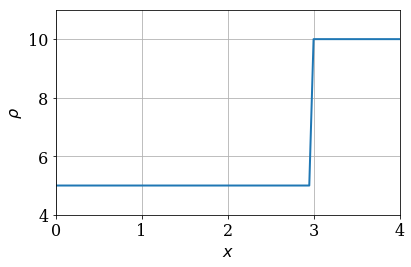

In [21]:
fig = pyplot.figure(figsize=(6.0, 4.0))
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$\rho$')
pyplot.grid()
line = pyplot.plot(x, rho0,
                   color='C0', linestyle='-', linewidth=2)[0]
pyplot.xlim(0.0, L)
pyplot.ylim(4.0, 11.0)
pyplot.tight_layout()

In [22]:
def flux(rho, u_max, rho_max):
    F = rho * u_max * (1.0 - rho / rho_max)
    return F

In [23]:
from matplotlib import animation
from IPython.display import HTML

In [24]:
def update_plot(n, rho_hist):
    fig.suptitle('Time step {:0>2}'.format(n))
    line.set_ydata(rho_hist[n])

In [25]:
def lax_friedrichs(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):
        # Compute the flux.
        F = flux(rho, *args)
        # Advance in time using Lax-Friedrichs scheme.
        rho[1:-1] = (0.5 * (rho[:-2] + rho[2:]) -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]))
        # Set the value at the first location.
        rho[0] = bc_values[0]
        # Set the value at the last location.
        rho[-1] = bc_values[1]
        # Record the time-step solution.
        rho_hist.append(rho.copy())
    return rho_hist

In [26]:
#Lax-Friedrichs
sigma = 1.0
dt = sigma * dx / u_max  
rho0     = rho_red_light(x,rho_max)
rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)

In [27]:
def plot_density(n, rho_hist):
   pyplot.figure(figsize=(8.0,4.0))
   pyplot.xlabel('Distance [km]')
   pyplot.ylabel('Density [cars / km]')
   pyplot.grid()
   pyplot.plot(x, rho_hist[0], label='Initial')
   pyplot.plot(x, rho_hist[n], label='Time step {}'.format(n))
   pyplot.ylim(rho_hist[0].min() - 1.0, rho_hist[0].max() + 1.0)
   pyplot.legend()

# create a ipywidgets slider for the time levels
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1,
                                description='time step')

# create the ipywidgets interactive figure
w = ipywidgets.interactive(plot_density,
                              n=nt_slider,
                              rho_hist=ipywidgets.fixed(rho_hist))

# display the interactive figure
display(w)

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [28]:
# What do you see in the animation above? How does the numerical solution compare with the exact solution:
# The wave is traveling to the left,it has the same initial Density and finally reaches the same density. 
#It looks like the left-travelling shock wave but has some errors.
# dissipation error
# This method is first order accurate in time and second order accurate in space, it's a way to solute
# problems about some hyperbolic partial differential equations based on finite differences but it has its own large errors.

In [13]:
sigma = 0.5
dt = sigma * dx / u_max


rho_hist = lax_friedrichs(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                          u_max, rho_max)


In [29]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

HTML(anim.to_html5_video())

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [30]:
def plot_density(n, rho_hist):
   pyplot.figure(figsize=(8.0,4.0))
   pyplot.xlabel('Distance [km]')
   pyplot.ylabel('Density [cars / km]')
   pyplot.grid()
   pyplot.plot(x, rho_hist[0], label='Initial')
   pyplot.plot(x, rho_hist[n], label='Time step {}'.format(n))
   pyplot.ylim(rho_hist[0].min() - 1.0, rho_hist[0].max() + 1.0)
   pyplot.legend()

# create a ipywidgets slider for the time levels
nt_slider = ipywidgets.IntSlider(value=0, min=0, max=nt, step=1,
                                description='time step')

# create the ipywidgets interactive figure
w = ipywidgets.interactive(plot_density,
                              n=nt_slider,
                              rho_hist=ipywidgets.fixed(rho_hist))

# display the interactive figure
display(w)

interactive(children=(IntSlider(value=0, description='time step', max=40), Output()), _dom_classes=('widget-in…

In [31]:
def jacobian(rho, u_max, rho_max):
    J = u_max * (1.0 - 2.0 * rho / rho_max)
    return J


In [32]:
def lax_wendroff(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    for n in range(nt):

        F = flux(rho, *args)

        J = jacobian(rho, *args)

        rho[1:-1] = (rho[1:-1] -
                     dt / (2.0 * dx) * (F[2:] - F[:-2]) +
                     dt**2 / (4.0 * dx**2) *
                     ((J[1:-1] + J[2:]) * (F[2:] - F[1:-1]) -
                      (J[:-2] + J[1:-1]) * (F[1:-1] - F[:-2])))

        rho[0] = bc_values[0]

        rho[-1] = bc_values[1]

        rho_hist.append(rho.copy())
    return rho_hist

In [33]:
sigma = 1.0
dt = sigma * dx / u_max  

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [19]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
HTML(anim.to_html5_video())

In [20]:
sigma = 0.5
dt = sigma * dx / u_max 

rho_hist = lax_wendroff(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                        u_max, rho_max)

In [21]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)
HTML(anim.to_html5_video())

In [22]:
def maccormack(rho0, nt, dt, dx, bc_values, *args):
    rho_hist = [rho0.copy()]
    rho = rho0.copy()
    rho_star = rho.copy()
    for n in range(nt):

        F = flux(rho, *args)

        rho_star[1:-1] = (rho[1:-1] -
                          dt / dx * (F[2:] - F[1:-1]))

        F = flux(rho_star, *args)

        rho[1:-1] = 0.5 * (rho[1:-1] + rho_star[1:-1] -
                           dt / dx * (F[1:-1] - F[:-2]))

        rho[0] = bc_values[0]

        rho[-1] = bc_values[1]

        rho_hist.append(rho.copy())
    return rho_hist

In [23]:
sigma = 1.0
dt = sigma * dx / u_max  

rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [24]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

HTML(anim.to_html5_video())

In [25]:
sigma = 0.5
dt = sigma * dx / u_max

rho_hist = maccormack(rho0, nt, dt, dx, (rho0[0], rho0[-1]),
                      u_max, rho_max)

In [26]:
anim = animation.FuncAnimation(fig, update_plot,
                               frames=nt, fargs=(rho_hist,),
                               interval=100)

HTML(anim.to_html5_video())